In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim
import PIL
from PIL import Image
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pandas as pd
import seaborn
from facenet_pytorch import MTCNN
import mediapipe as mp
import cv2

In [5]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
#                          tt.Normalize((0.5), (0.5), inplace=True),
                         tt.Resize(64), 
#                          tt.RandomCrop(64, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor()])              # transform it into a PyTorch Tensor

test_transforms =   tt.Compose([
                    tt.Resize(64),              # resize the image to 64x64 
                    tt.ToTensor()])             # transform it into a PyTorch Tensor

In [6]:
data_dir = './gestures/'
data_dataset = ImageFolder(data_dir, train_transforms)

In [7]:
classes_train = os.listdir(data_dir)
print(f'Train Classes - {classes_train}')

Train Classes - ['C', 'fist', 'L', 'ok', 'palm', 'peace']


In [8]:
digit_to_classname = {0:'C', 1:'L', 2:'fist', 3:'ok', 4:'palm', 5:'peace'}

In [9]:
data_dataset

Dataset ImageFolder
    Number of datapoints: 2956
    Root location: ./gestures/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=64, interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [10]:
n = len(data_dataset)  # total number of examples
n_test = int(0.2 * n)  # take ~20% for test
test_dataset = torch.utils.data.Subset(data_dataset, range(n_test))  # take first 20%
train_dataset = torch.utils.data.Subset(data_dataset, range(n_test, n))

In [11]:
batch_size = 32

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 64, 71])


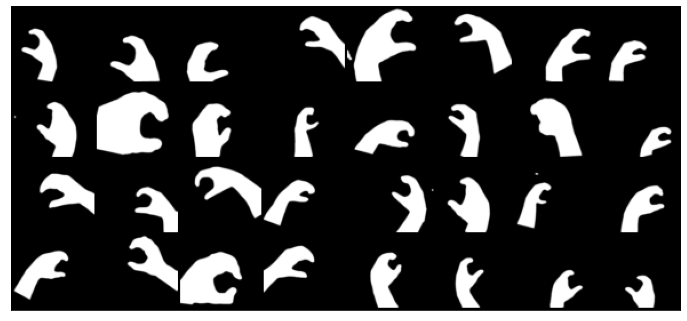

In [14]:
show_batch(test_dataloader)

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [19]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes),
                                        nn.Softmax(dim=1))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [16]:
model = to_device(ResNet(1, len(classes_train)), device)

In [17]:
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 150
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr)

In [18]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

150 epochs, 74 total_steps per epoch


In [19]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [20]:
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = data.cuda(), labels.cuda()       
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
#         print(outputs[0])
        #print(labels[0])
        _, preds = torch.max(outputs, 1)
        #print(preds)
        
        true_y.append(labels.to('cpu'))
        pred_y.append(outputs.to('cpu'))
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

Epoch 1, loss:  1.7586583027968536
Epoch 2, loss:  1.7034427700815975
Epoch 3, loss:  1.619747649978947
Epoch 4, loss:  1.4762337836059365
Epoch 5, loss:  1.435891792580888
Epoch 6, loss:  1.4082976273588232
Epoch 7, loss:  1.394031332956778
Epoch 8, loss:  1.3826650896587886
Epoch 9, loss:  1.3729751077858177
Epoch 10, loss:  1.346668494714273
Epoch 11, loss:  1.3251362813485634
Epoch 12, loss:  1.311763557227882
Epoch 13, loss:  1.3093457511953406
Epoch 14, loss:  1.3008618322578636
Epoch 15, loss:  1.2998659723513835
Epoch 16, loss:  1.2972582385346696
Epoch 17, loss:  1.2971536742674339
Epoch 18, loss:  1.2917138773041803
Epoch 19, loss:  1.2992133755941648
Epoch 20, loss:  1.2891364661422935
Epoch 21, loss:  1.290776033659239
Epoch 22, loss:  1.294044399583662
Epoch 23, loss:  1.289477308054228
Epoch 24, loss:  1.2907499316576365
Epoch 25, loss:  1.286640615076632
Epoch 26, loss:  1.2866249857722103
Epoch 27, loss:  1.2847345116976145
Epoch 28, loss:  1.2849636238974493
Epoch 29, 

Text(0.5, 1.0, 'losses vs. No. of epochs')

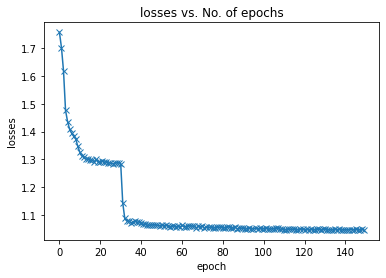

In [21]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [23]:
torch.save(model.state_dict(), './models/emotion_detection_model_state_150_epochs.pth')

In [20]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('./models/emotion_detection_model_state_150_epochs.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

torch.Size([32, 1, 64, 71])
torch.Size([6])


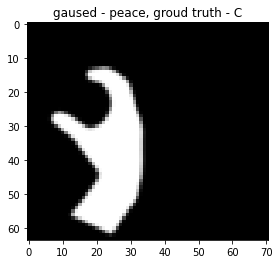

torch.Size([32, 1, 64, 71])
torch.Size([6])


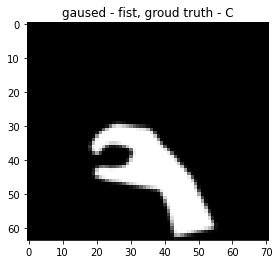

torch.Size([32, 1, 64, 71])
torch.Size([6])


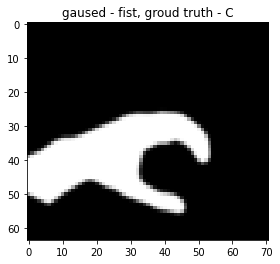

torch.Size([32, 1, 64, 71])
torch.Size([6])


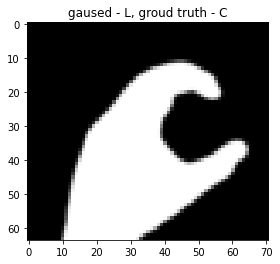

torch.Size([32, 1, 64, 71])
torch.Size([6])


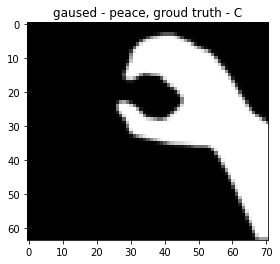

torch.Size([32, 1, 64, 71])
torch.Size([6])


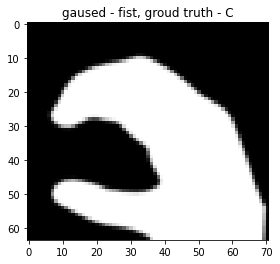

torch.Size([32, 1, 64, 71])
torch.Size([6])


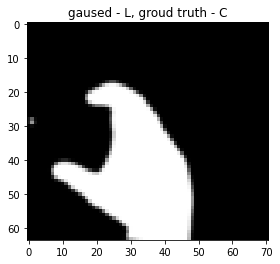

torch.Size([32, 1, 64, 71])
torch.Size([6])


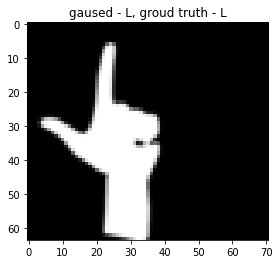

torch.Size([32, 1, 64, 71])
torch.Size([6])


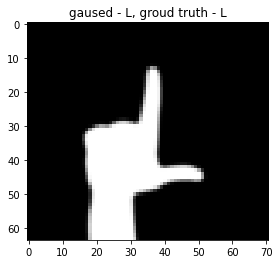

torch.Size([32, 1, 64, 71])
torch.Size([6])


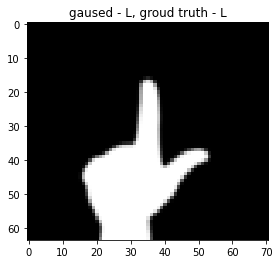

torch.Size([32, 1, 64, 71])
torch.Size([6])


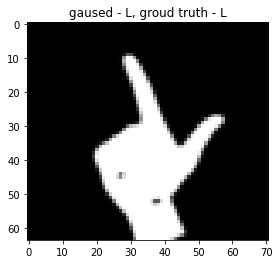

torch.Size([32, 1, 64, 71])
torch.Size([6])


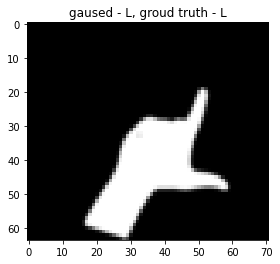

In [32]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = images, labels
        outputs = net(images)
        print(images.shape)
        print(outputs[0].shape)
        plt.title(f'gaused - {digit_to_classname[outputs[0].argmax().item()]}, groud truth - {digit_to_classname[labels[0].data.item()]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

In [39]:
import numpy as np
from facenet_pytorch import MTCNN
from PIL import Image
import mediapipe as mp
import cv2
# mp_drawing = mp.solutions.drawing_utils
# mp_hands = mp.solutions.hands
 

# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn, mp, resnet,channels=1):
        # Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
        self.cap = cv2.VideoCapture(0) 
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = resnet
        self.channels = channels
        self.mp = mp

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
                

                # Рисуем особенные точки
#                 cv2.circle(frame, (int(ld[0][0]),int(ld[0][1])), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, (int(ld[1][0]),int(ld[1][1])), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, (int(ld[2][0]),int(ld[2][1])), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, (int(ld[3][0]),int(ld[3][1])), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, (int(ld[4][0]),int(ld[4][1])), 5, (0, 0, 255), -1)
        except Exception as e:
            print('Something wrong im draw function!')
            print(f'error : {e}')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]-40):int(box[3]+40), 
                int(box[0]-40):int(box[2]+40)])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'C'
        elif digit == 1:
            return 'L'
        elif digit == 2:
            return 'fist'
        elif digit == 3:
            return 'ok'
        elif digit == 4:
            return 'palm'
        elif digit == 5:
            return 'peace'
        
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):
        mp_drawing = self.mp.solutions.drawing_utils
        mp_hands = self.mp.solutions.hands
        with mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
        # Заходим в бесконечный цикл
            while True:
                # Считываем каждый новый кадр - frame
                # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
                ret, frame = self.cap.read()
                h, w, c = frame.shape
                try:
                    # детектируем расположение лица на кадре, вероятности на сколько это лицо
                    # и особенные точки лица
                    boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)


    #                 # Вырезаем лицо из кадра
    #                 face = self.crop_faces(frame, boxes)[0]
    #                 # Меняем размер изображения лица для входа в нейронную сеть
    #                 face_img = cv2.resize(face,(48,48))
    #                 face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    #                 # Превращаем в 1-канальное серое изображение
    #                 face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    #                 # Далее мы подготавливаем наш кадр для считывания нс
    #                 # Для этого перегоним его в формат pil_image
    #                 face = Image.fromarray(face)
    #                 #face = face.resize((48,48))
    #                 face = np.asarray(face).astype('float')
    #                 face = torch.as_tensor(face)


    #                 # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
    #                 torch_face = face.unsqueeze(0).to(self.device).float()
    #                 # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
    #                 emotion = self.emodel(torch_face[None, ...])
    #                 # Интерпретируем предсказание как строку нашей эмоции
    #                 emotion = self.digit_to_classname(emotion[0].argmax().item())

                    # Рисуем на кадре
                    self._draw(frame, boxes, probs, landmarks)
                    vector_list = []

                    frame = cv2.cvtColor(cv2.flip(frame, 1), cv2.COLOR_BGR2RGB)
                    # To improve performance, optionally mark the image as not writeable to
                    # pass by reference.
                    frame.flags.writeable = False
                    results = hands.process(frame)

                    # Draw the hand annotations on the image.
                    frame.flags.writeable = True
                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                    hand_landmarks = results.multi_hand_landmarks
#                     if hand_landmarks:
#                         for handLMs in hand_landmarks:
#                             x_max = 0
#                             y_max = 0
#                             x_min = w
#                             y_min = h
#                             for lm in handLMs.landmark:
#                                 x, y = int(lm.x * w), int(lm.y * h)
#                                 if x > x_max:
#                                     x_max = x
#                                 if x < x_min:
#                                     x_min = x
#                                 if y > y_max:
#                                     y_max = y
#                                 if y < y_min:
#                                     y_min = y
#                         cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
#                         mp_drawing.draw_landmarks(frame, handLMs, mp_hands.HAND_CONNECTIONS)
#                         face = self.crop_faces(frame, handLMs)
#                         # Меняем размер изображения лица для входа в нейронную сеть
#                         face_img = cv2.resize(face,(64,64))
#                         face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
#                         # Превращаем в 1-канальное серое изображение
#                         face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

#                         # Далее мы подготавливаем наш кадр для считывания нс
#                         # Для этого перегоним его в формат pil_image
#                         face = Image.fromarray(face)
#                         #face = face.resize((48,48))
#                         face = np.asarray(face).astype('float')
#                         face = torch.as_tensor(face)


#                         # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
#                         torch_face = face.unsqueeze(0).to(self.device).float()
#                         # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
#                         emotion = self.emodel(torch_face[None, ...])
#                         # Интерпретируем предсказание как строку нашей эмоции
#                         emotion = self.digit_to_classname(emotion[0].argmax().item())
    
                    if results.multi_hand_landmarks:
                      for hand_landmarks in results.multi_hand_landmarks:
#                         for point in range(len(results.multi_hand_landmarks[0].landmark)):
#                             vector_list.append(hand_landmarks.landmark[point].x)
#                             vector_list.append(hand_landmarks.landmark[point].y)                        
#                             vector_list.append(hand_landmarks.landmark[point].z)
                        mp_drawing.draw_landmarks(
                            frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    
                    bgModel = cv2.BackgroundSubtractorMOG2(0, 50)
                    fgmask = bgModel.apply(frame, learningRate=0)
                    kernel = np.ones((3, 3), np.uint8)
                    fgmask = cv2.erode(fgmask, kernel, iterations=1)
                    img = cv2.bitwise_and(frame, frame, mask=fgmask)
                    
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    blur = cv2.GaussianBlur(gray, (41, 41), 0)
                    ret, thresh = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                    hands_img = cv2.resize(thresh, (64, 71))
                    hands = cv2.cvtColor(hands_img, cv2.COLOR_BGR2RGB)
                    hands = cv2.cvtColor(hands, cv2.COLOR_BGR2GRAY)
                    hands = Image.fromarray(hands)
                    hands = np.asarray(hands).astype('float')
                    hands = torch.as_tensor(hands)


    #                 # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                    torch_hands = hands.unsqueeze(0).to(self.device).float()
    #                 # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                    emotion = self.emodel(torch_hands[None, ...])
    #                 # Интерпретируем предсказание как строку нашей эмоции
                    emotion = self.digit_to_classname(emotion[0].argmax().item())
#                     cv2.imshow("Gray face", face_img)
#                     prob = torch.tensor(np.array(vector_list), dtype=torch.float, device=device)
#                     prob = torch.reshape(prob, (1, images.shape))
#                     result = self.emodel(prob)
#                     emotion = self.digit_to_classname(result)[0]
                    cv2.putText(frame, emotion,
                         (int(box[2]), int(box[3])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                except Exception as e:
                    print('Something wrong im main cycle!')
                    print(f'error : {e}')

                # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
                cv2.imshow('Hands Detection', frame)


                # Функция, которая проверяет нажатие на клавишу 'q'
                # Если нажатие произошло - выход из цикла. Конец работы приложения
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()

In [42]:
mtcnn = MTCNN()
device = torch.device("cuda")
model = net.to(device)
model.load_state_dict(torch.load('./models/emotion_detection_model_state_150_epochs.pth'))

# ourResNet = FERModel(1, 7).to(device)
# ourResNet.load_state_dict(torch.load('./models/model2_50_epochs.pth'))


ourResNet.eval()
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn, mp, model)
# Запускаем
fcd.run()

Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception from OpenCV code
Something wrong im main cycle!
error : Unknown C++ exception fro